In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pwlf
from numpy import genfromtxt
from hmmlearn import hmm
np.random.seed(42)

### Load force and strain profiles

##### Note:
- The force profiles are the actual measurements
- The strain profiles are *inferred* from the force profiles and the approximate model of cutting process. We model the process of cutting the skin mimicking phantom as continuous strain application to perfect Maxwell material. 
- The strain profiles can then be estimated by the inverse of the Maxwell viscoelastic model. In Laplace domain this can be expressed as

$$G_{\varepsilon f}(s) = \frac{\varepsilon (s)}{F(s)} = \frac{1}{E} + \frac{1}{\eta} \cdot \frac{1}{s}$$, where $E$ is elastic modulus and $\eta$ is viscosity.

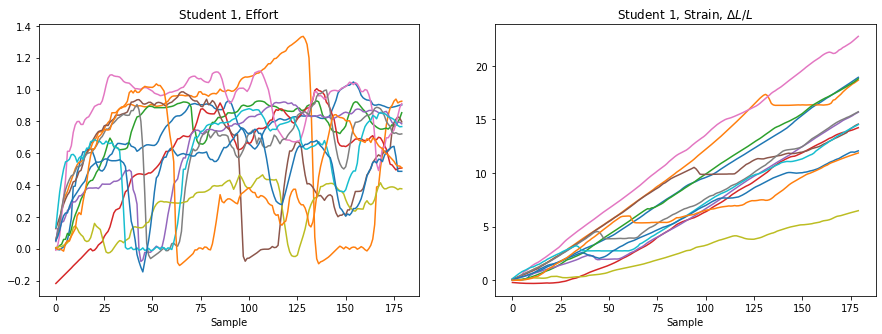

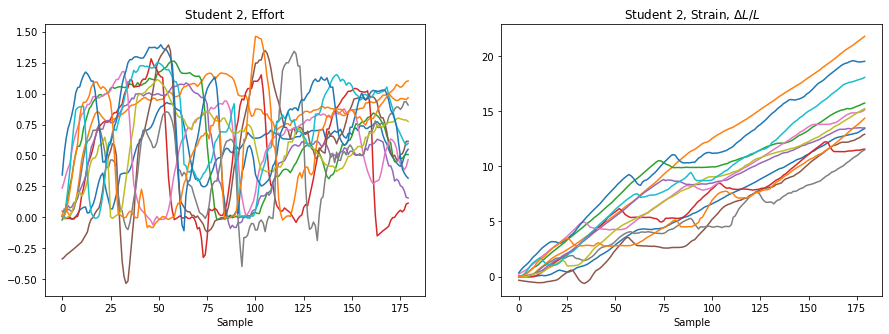

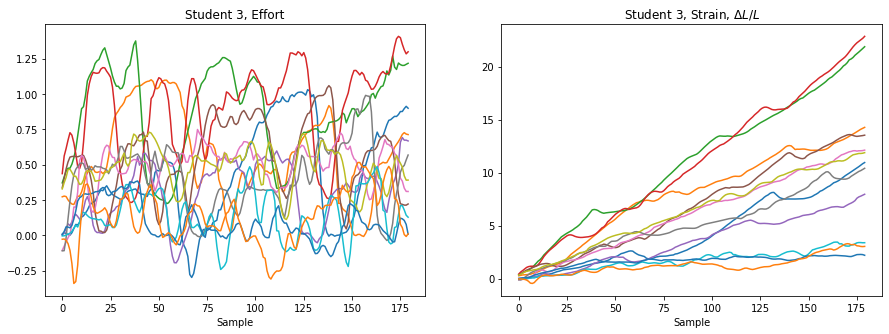

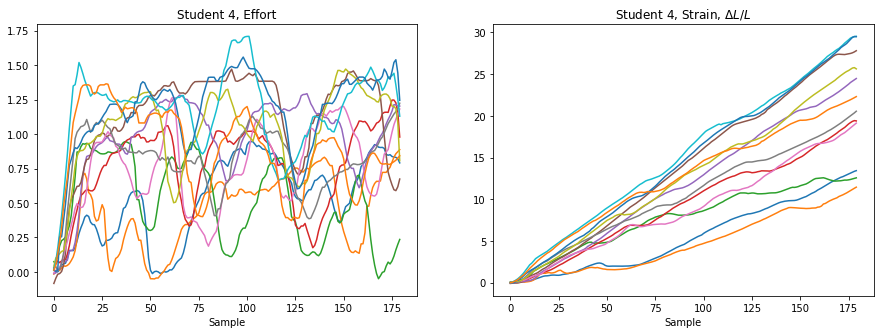

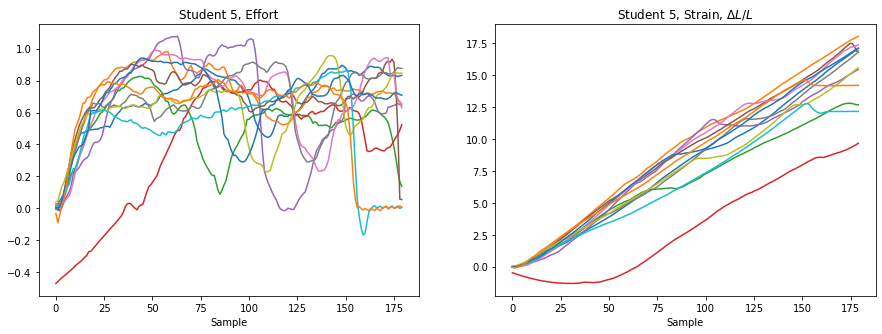

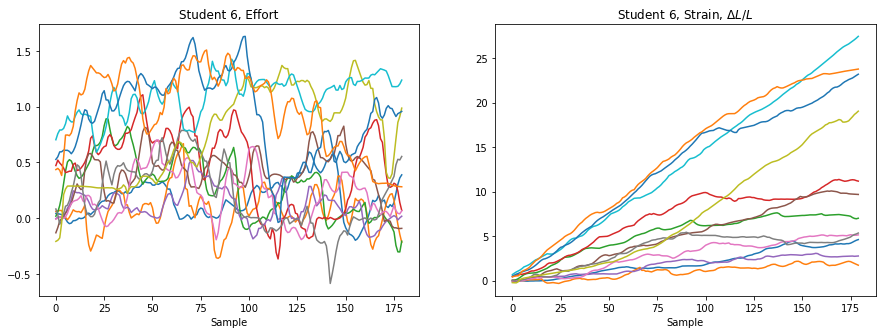

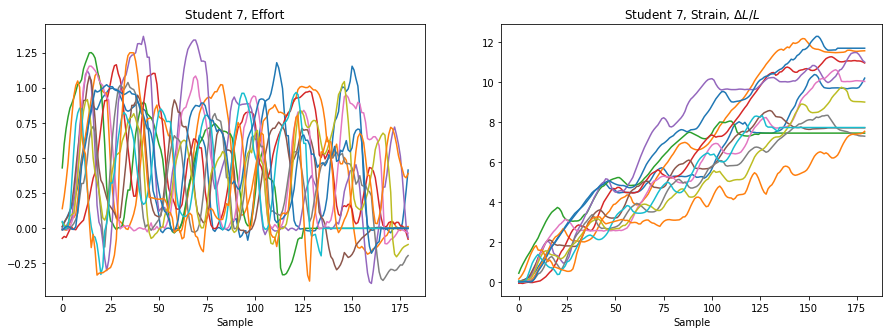

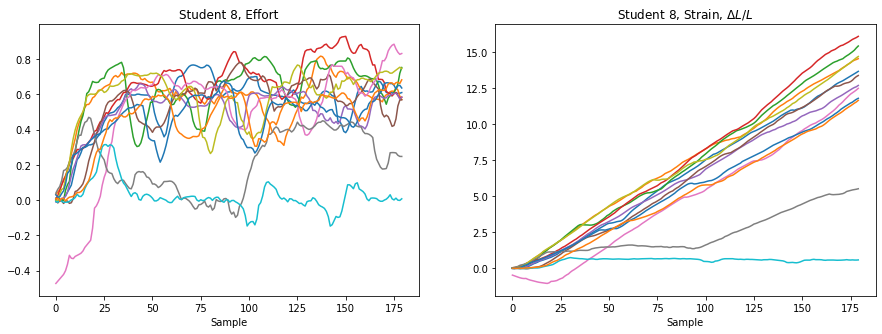

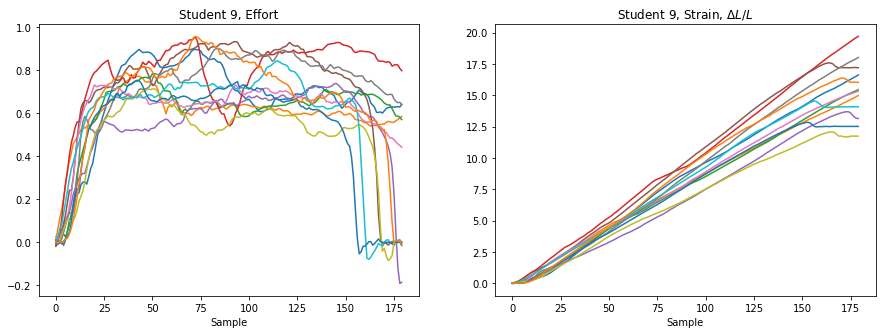

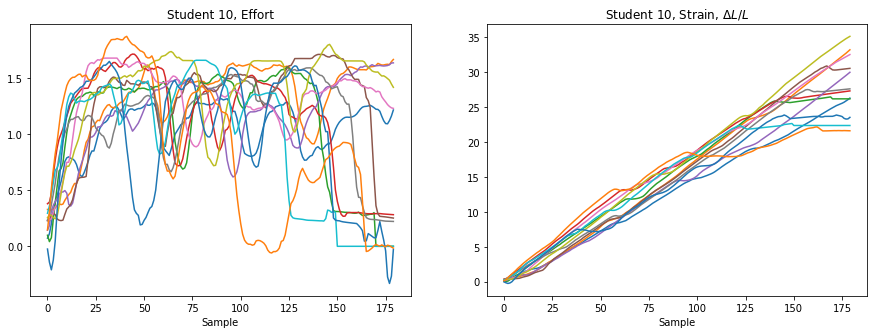

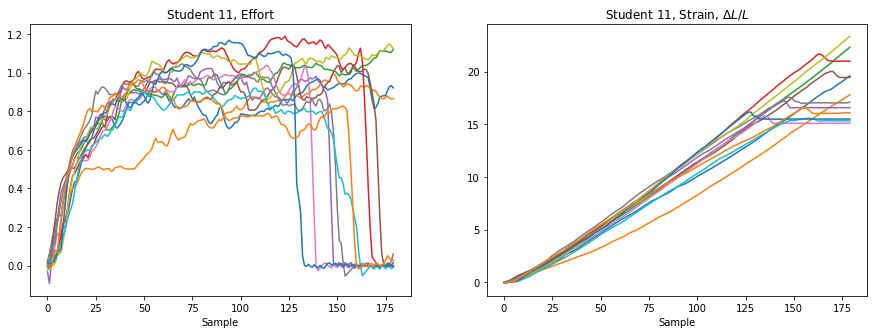

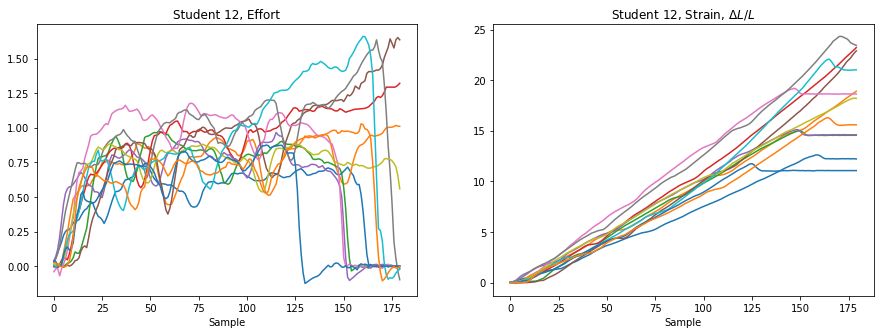

In [2]:
student_force = np.zeros([12,12,180]) # 12 students, 12 cuts, 180 samples
student_strain = np.zeros([12,12,180]) # 12 students, 12 cuts, 180 samples

for student in range(12):
    for cut in range(12):
        student_force[student,cut,:] = genfromtxt('./data/student_'+str(student+1)+'_force_'+str(cut+1)+'.csv', delimiter=',')
        student_strain[student,cut,:] = genfromtxt('./data/student_'+str(student+1)+'_strain_'+str(cut+1)+'.csv', delimiter=',')
        
for student in range(12):

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    for cut in range(12):
        plt.plot(student_force[student,cut,:])
    plt.title('Student '+str(student+1)+', Effort')
    plt.xlabel('Sample')
    
    plt.subplot(1,2,2)
    for cut in range(12):
        plt.plot(student_strain[student,cut,:])
    plt.title('Student '+str(student+1)+', Strain, $\Delta L/L$')
    plt.xlabel('Sample')


### Markov Chain for linear strain model

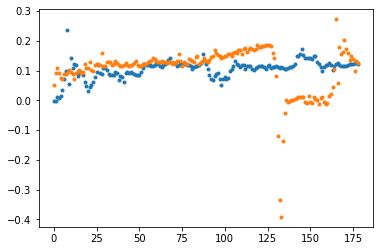

In [4]:
plt.plot(np.diff(student_strain[0,0,:]),'.')
plt.plot(np.diff(student_strain[0,1,:]),'.')

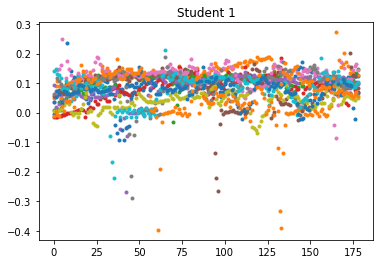

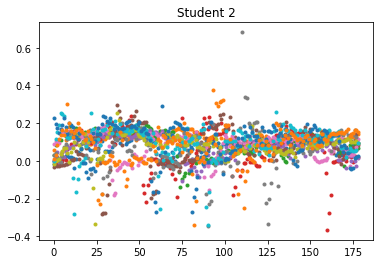

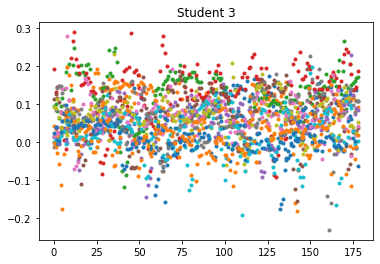

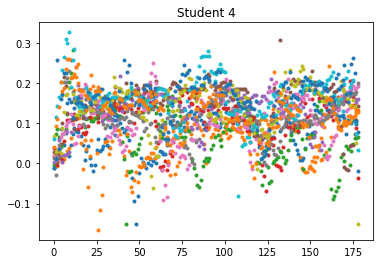

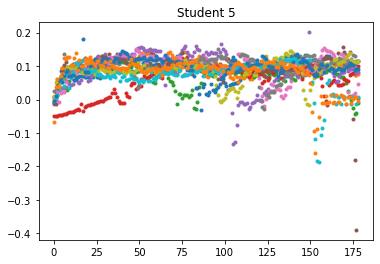

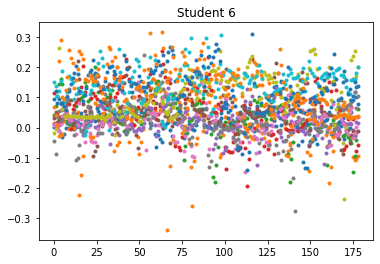

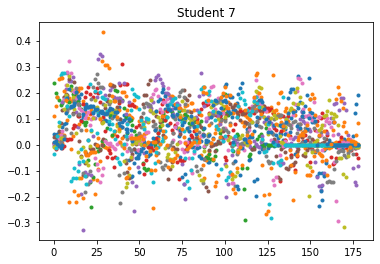

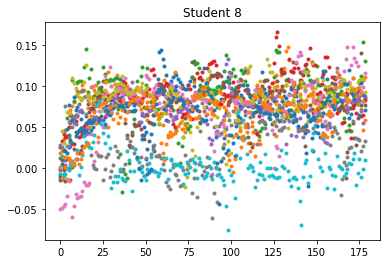

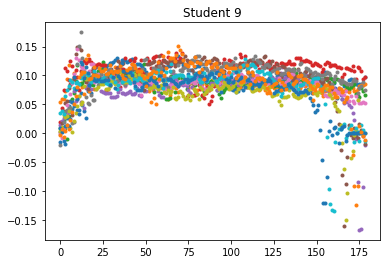

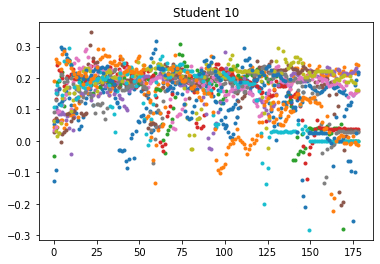

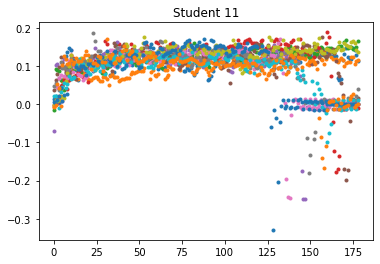

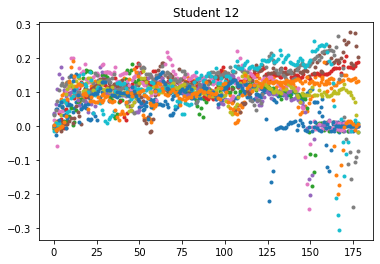

In [5]:
# Plot linear model parameters (slope and duration of linear segments) for each of the student

for student in range(12):
    for cut in range(12):
        plt.plot(np.diff(student_strain[student,cut,:]),'.')
    plt.title('Student '+str(student+1))
    plt.show()

In [6]:
# Collect sequence of states for each of the cuts

sequence = np.zeros([12,2148]) # [student,12 cut x 180 state transitions, slope]

for student in range(12):
    
    seq = []
    for cut in range(12):
        seq.append(np.diff(student_strain[student,cut,:]))
    
    sequence[student,:] = np.array(seq).reshape(-1)

In [14]:
# Fit HMM for each student
# Each student HMM model is fit on 12 cutting sequence 

hmm_model = []

for student in range(12):
    
    model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
    model.fit(sequence[student,:].reshape(-1,1), 179*np.ones(12,dtype='int32'))
    hmm_model.append(model)

In [9]:
# Convert strain rate to force using Maxwell model (E = 1, eta = 0.25)
def v2f(state,u,dt=0.0333):
    return state -4*state*dt + u*dt

# Given the strain profile and residuals model, generate the force profile
def get_force(strain_rate):
    
    dt = 0.0333
    forces = [0]

    for i in range(178):
        forces.append(v2f(forces[-1],(strain_rate[i]/dt)))
    
    return np.array(forces)

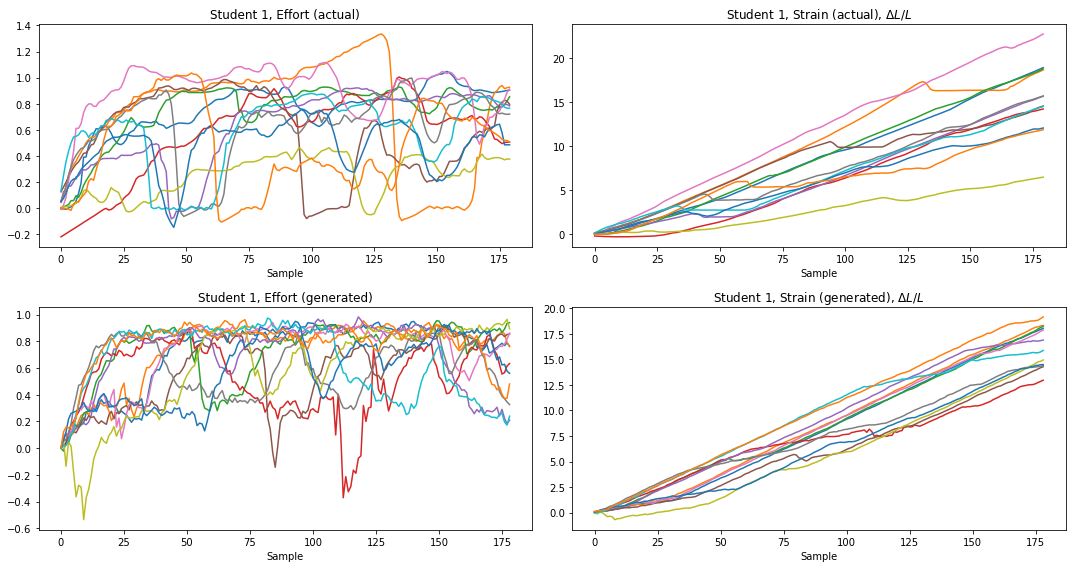

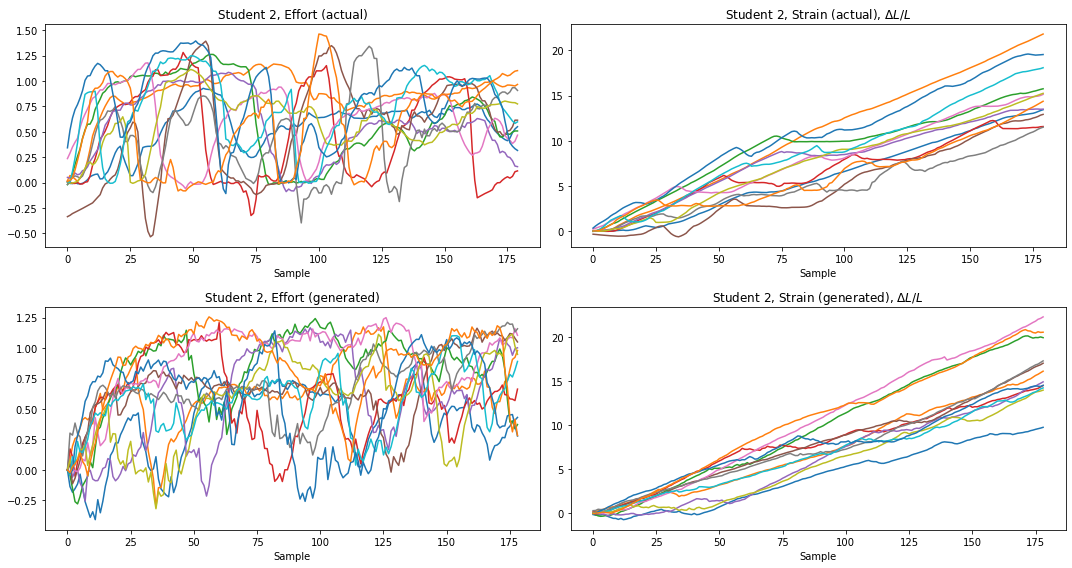

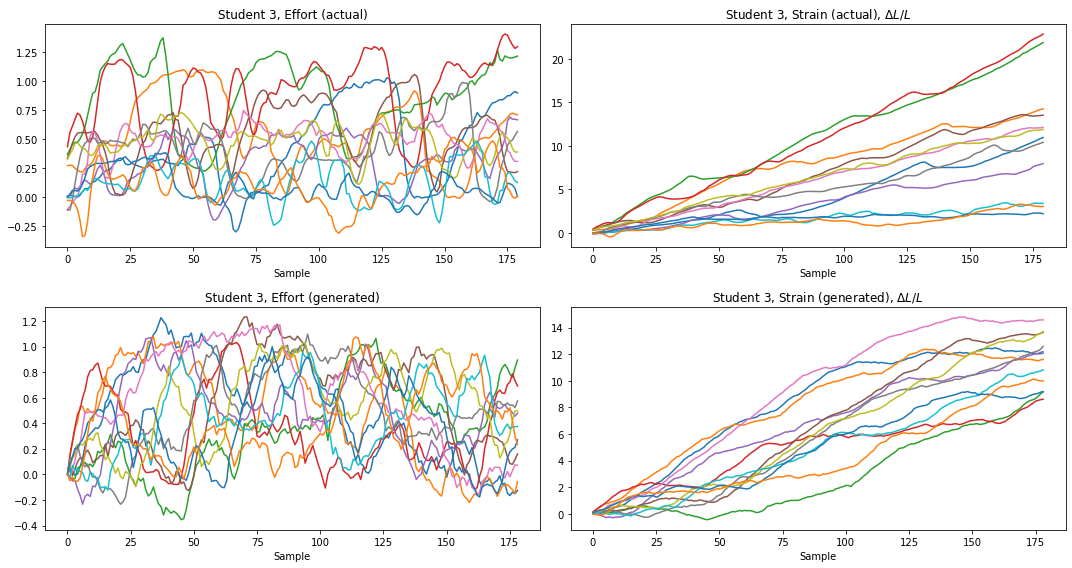

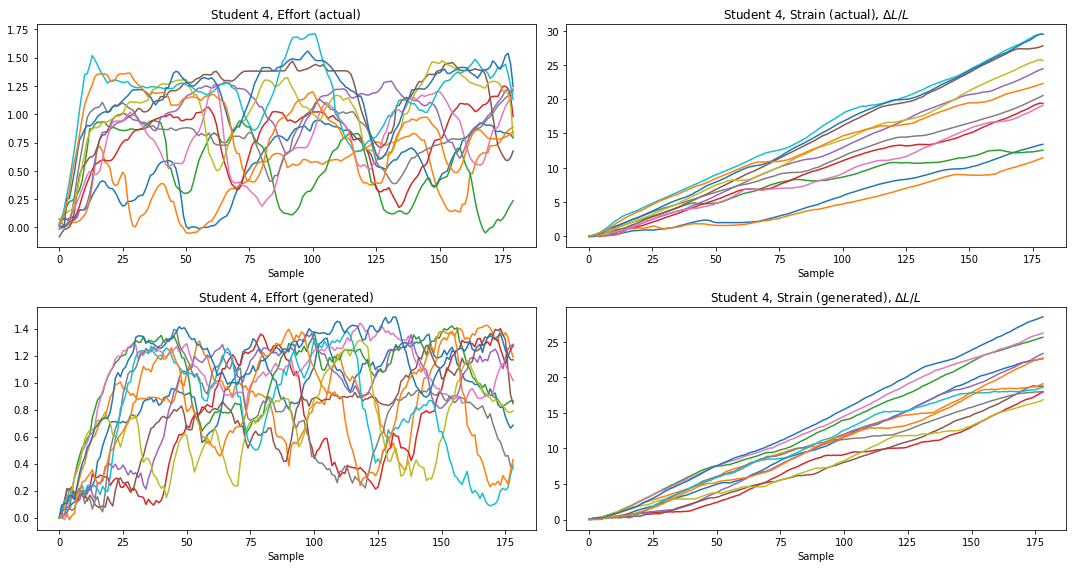

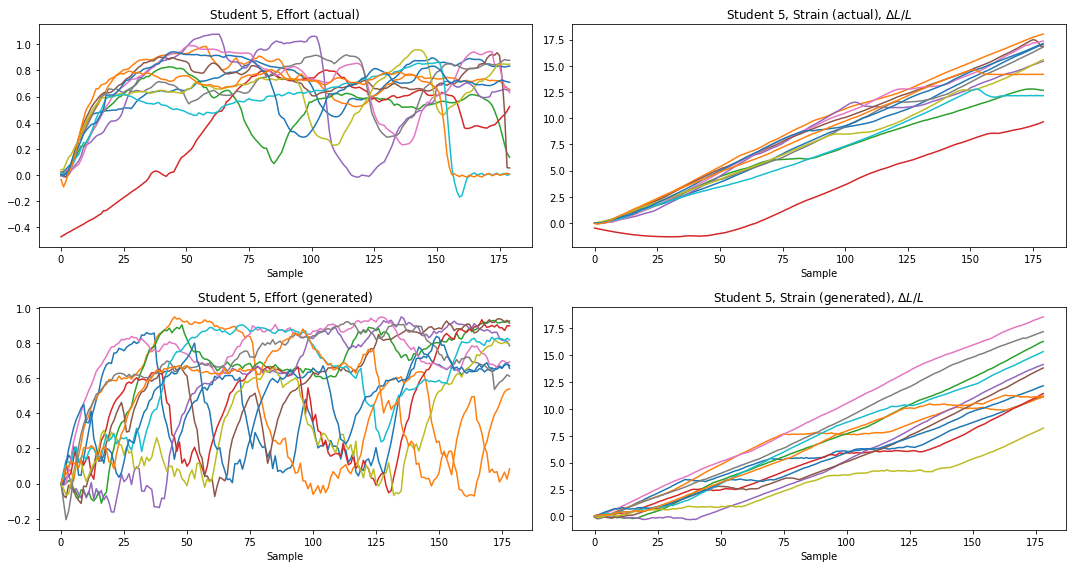

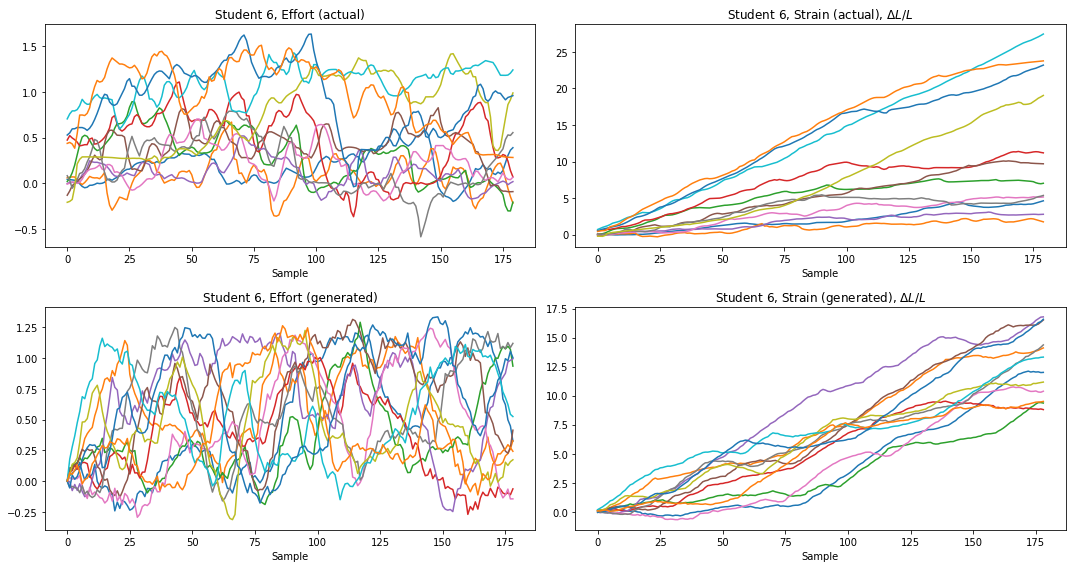

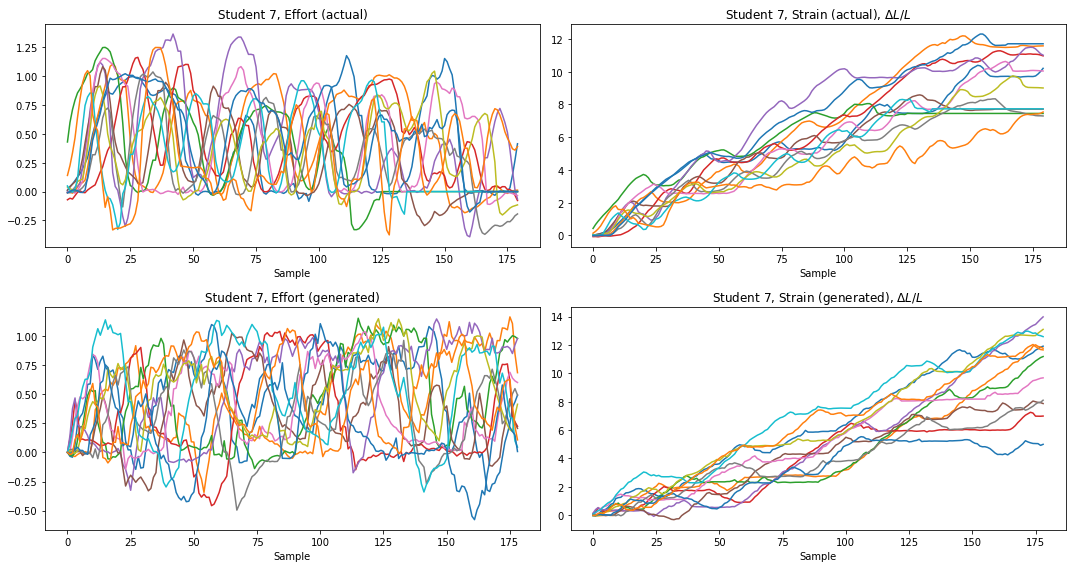

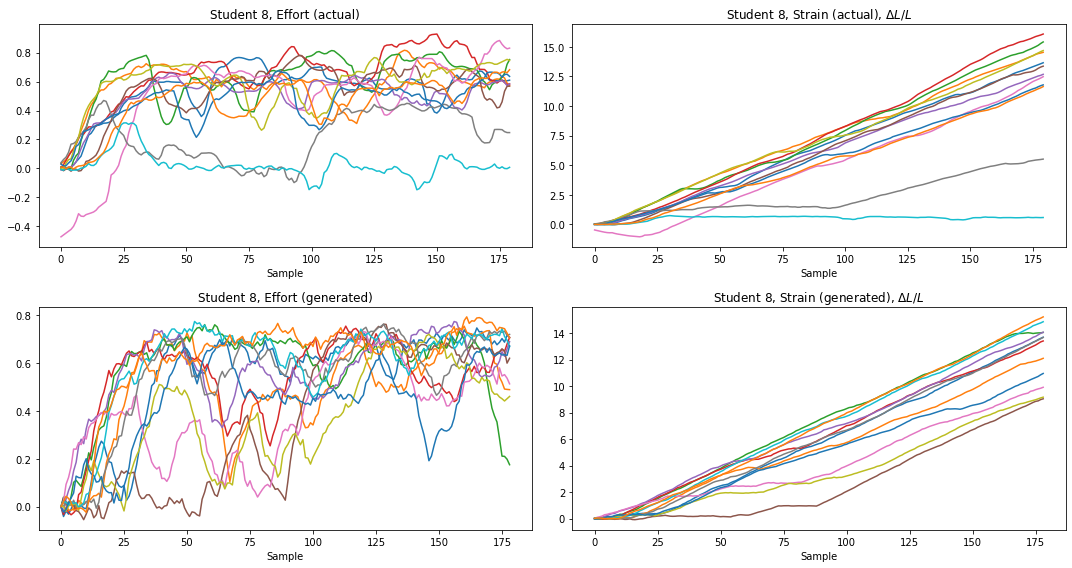

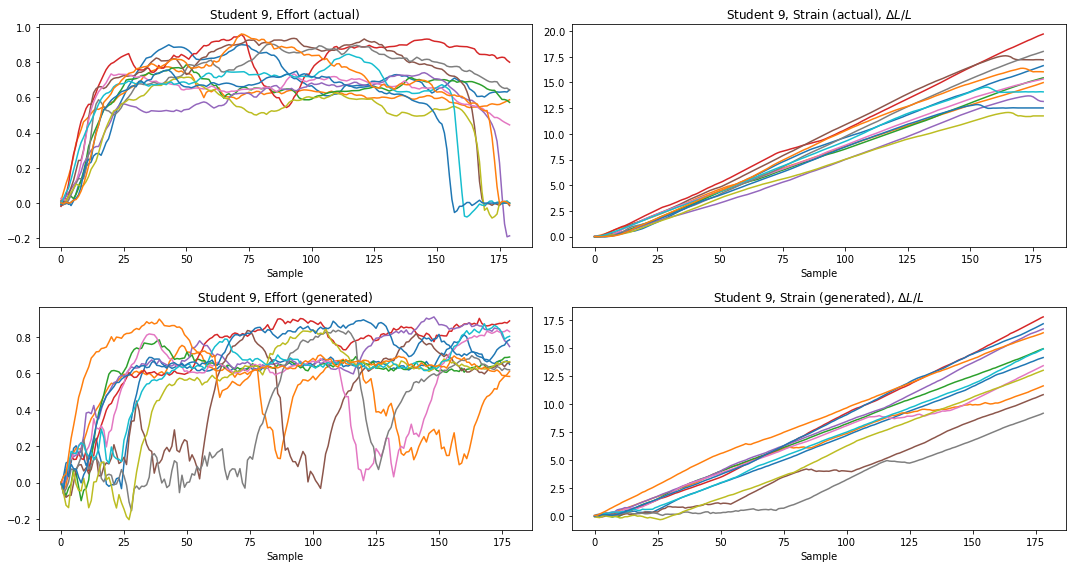

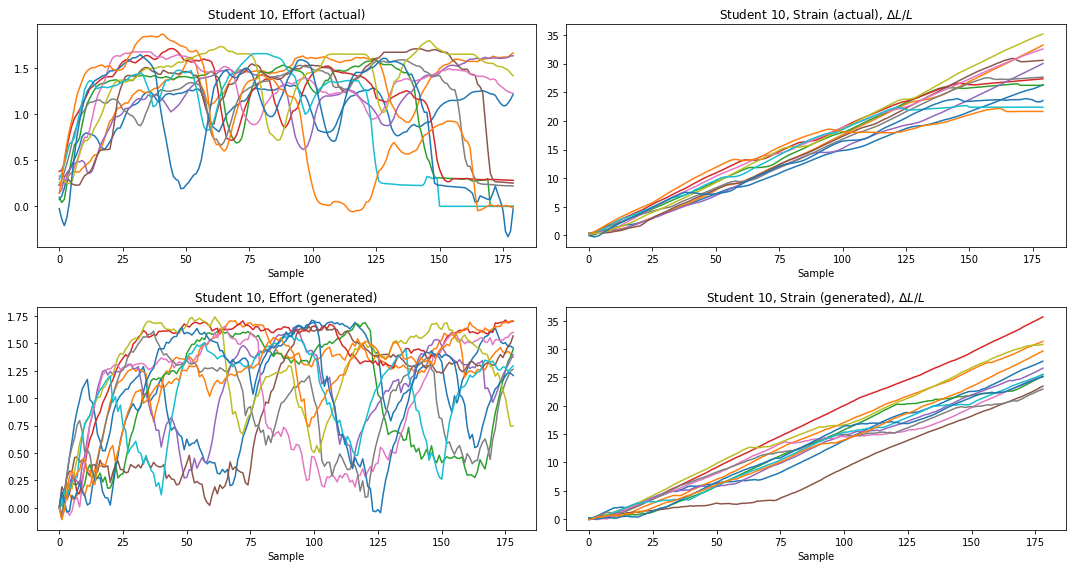

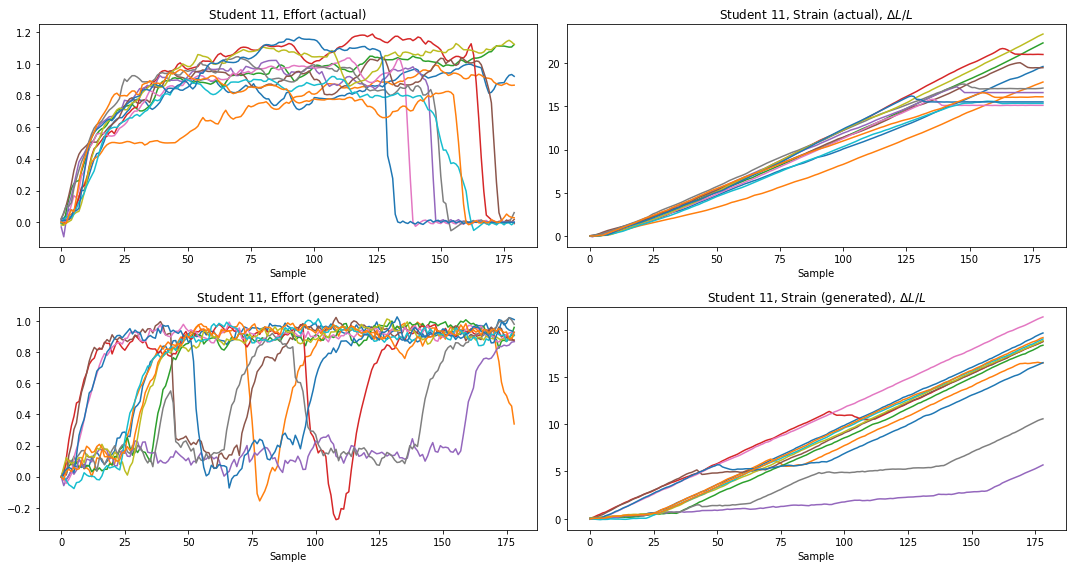

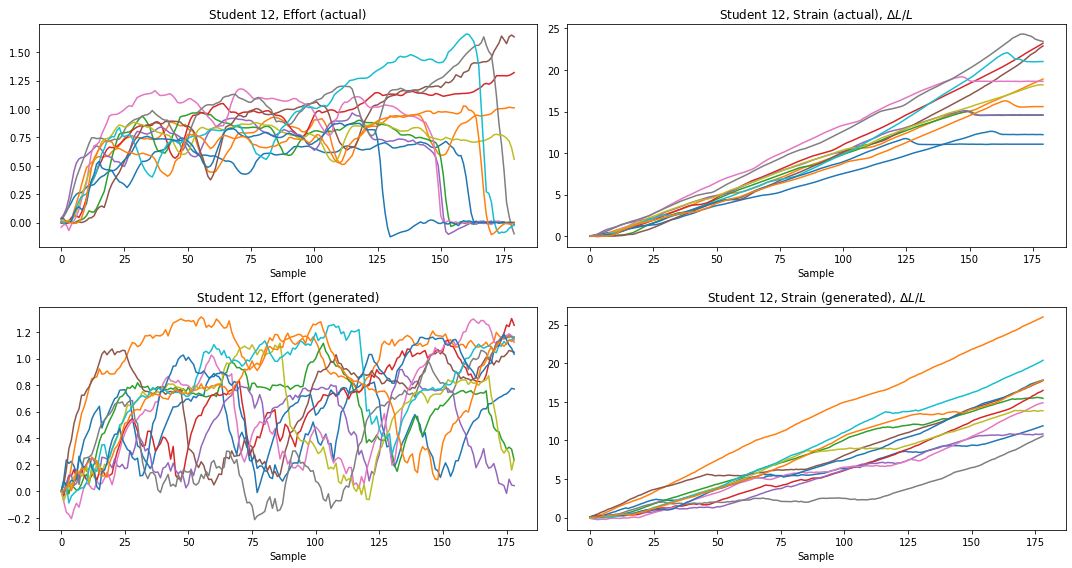

In [15]:
student_strain_gen = np.zeros([12,12,179])
student_force_gen = np.zeros([12,12,179])

for student in range(12):
    for cut in range(12):
    
        X,_ = hmm_model[student].sample(179)
        
        student_strain_gen[student,cut,:] = np.cumsum(X.reshape(-1))
        student_force_gen[student,cut,:] = get_force(X.reshape(-1))    
        

for student in range(12):

    plt.figure(figsize=(15,8))
    
    plt.subplot(2,2,1)
    for cut in range(12):
        plt.plot(student_force[student,cut,:])
    plt.title('Student '+str(student+1)+', Effort (actual)')
    plt.xlabel('Sample')
    
    plt.subplot(2,2,2)
    for cut in range(12):
        plt.plot(student_strain[student,cut,:])
    plt.title('Student '+str(student+1)+', Strain (actual), $\Delta L/L$')
    plt.xlabel('Sample')
    
    plt.subplot(2,2,3)
    for cut in range(12):
        plt.plot(student_force_gen[student,cut,:])
    plt.title('Student '+str(student+1)+', Effort (generated)')
    plt.xlabel('Sample')
    
    plt.subplot(2,2,4)
    for cut in range(12):
        plt.plot(student_strain_gen[student,cut,:])
    plt.title('Student '+str(student+1)+', Strain (generated), $\Delta L/L$')
    plt.xlabel('Sample')
    
    plt.tight_layout()